# Подготовка среды

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shared drives/hse_BERT/hse_Af_Tr_BERT')

In [ ]:
!pip install transformers

In [ ]:
!pip install razdel

In [ ]:
import torch
import nltk
import re
import json
import time
import numpy as np
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

from scipy.spatial.distance import cosine

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
model.eval()

In [ ]:
import pickle as pc

def my_dump(file, name):
    with open("./bin/" + name + ".pic", 'wb') as f:
        pc.dump(file, f)

def my_load(name):
    with open("./bin/" + name + ".pic", 'rb') as f:
        return pc.load(f)

In [ ]:
from razdel import sentenize

# short 

## generate (split) sentences

In [ ]:
with open("./texts/all_cyberleninka_liter2/all_cyberleninka_liter2.txt", 'r') as f:
    data = f.read()

In [ ]:
%%time
sent1 = list(sentenize(data))

CPU times: user 5min 54s, sys: 2.37 s, total: 5min 56s
Wall time: 5min 57s


In [ ]:
%%time
my_dump(sent1, "sent1")
# my_dump(sent2, "sent2")

CPU times: user 20.2 s, sys: 2.33 s, total: 22.5 s
Wall time: 33 s


## read sentences

In [ ]:
%%time
sent1 = my_load("sent2")

CPU times: user 8.54 s, sys: 3.48 s, total: 12 s
Wall time: 24.3 s


In [ ]:
def get_text_from_ST(ss):
    return ss.text

In [ ]:
sent = list(map(get_text_from_ST, sent1))

In [ ]:
len(sent)

2348859

## work

In [ ]:
for_embeddings = {
    "король", 
    "королева",
    "мужчина",
    "женьщина"
}

In [ ]:
text = "консультация — это старинное название всей художественной литературы, король, королева, королю, королям, королем, королями"


In [ ]:
a, b = get_embeddings(text)
a

NameError: ignored

In [ ]:
def sum_tensors(token):
    return torch.sum(token[-4:], dim=0)

def get_embeddings(text):
    tokenized_text = tokenizer.tokenize("[CLS] " + text.lower() + " [SEP]")
    if len(tokenized_text) > 80:
        return [],[]
    marked_text = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([marked_text])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0),
                                    dim=1).permute(1,0,2)
    
    token_vecs_sum = list(map(sum_tensors, token_embeddings))
    return tokenized_text, token_vecs_sum

# token_vecs = hidden_states[-2][0]
# sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
# pr_tr = dict.fromkeys(for_embeddings)
# for i in pr_tr:
#     pr_tr[i] = []

# pr_tr

In [ ]:
# words = re.compile('\w+')
# words.fullmatch("khbkjhk")
# re.fullmatch(r'\w+', "12kb12lkjnl")

In [ ]:
# %%time
# for j in range(1):
#     for i in range(j * 100, (j + 1) * 100):
#         tt, tvs = get_embeddings(sent[i])
#         for i in range(len(tt)):
#             if tt[i].isalpha():
#                 if tt[i] in pr_tr:
#                     pr_tr[tt[i]].append(tvs[i])
#                 else:
#                     pr_tr[tt[i]] = [tvs[i]]

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(73, 100):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha()  and len(tt[i]) > 2:
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00073 --- time: 133.8255181312561	--- total: 133.83799266815186
done 00074 --- time: 127.67481923103333	--- total: 261.5333180427551
done 00075 --- time: 135.72998452186584	--- total: 397.28075432777405
done 00076 --- time: 134.0361351966858	--- total: 531.3412175178528
done 00077 --- time: 143.00810194015503	--- total: 674.3701372146606
done 00078 --- time: 137.19187116622925	--- total: 811.6049604415894
done 00079 --- time: 133.0364248752594	--- total: 944.6594543457031
done 00080 --- time: 129.9734537601471	--- total: 1074.653567790985
done 00081 --- time: 135.58954620361328	--- total: 1210.2656495571136
done 00082 --- time: 145.48880052566528	--- total: 1355.7759521007538
done 00083 --- time: 136.7935266494751	--- total: 1492.5957095623016
done 00084 --- time: 130.4651472568512	--- total: 1623.0832426548004
done 00085 --- time: 130.11635994911194	--- total: 1753.2208211421967
done 00086 --- time: 124.53188037872314	--- total: 1877.7737715244293
done 00087 --- time: 133.3682229

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(200, 300):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha()  and len(tt[i]) > 2:
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00200 --- time: 135.45572423934937	--- total: 135.48075079917908
done 00201 --- time: 123.5507218837738	--- total: 259.05382537841797
done 00202 --- time: 130.05737471580505	--- total: 389.1284713745117
done 00203 --- time: 135.37163496017456	--- total: 524.519100189209
done 00204 --- time: 131.47128868103027	--- total: 656.014101266861
done 00205 --- time: 134.73659801483154	--- total: 790.7700610160828
done 00206 --- time: 135.79944705963135	--- total: 926.591290473938
done 00207 --- time: 135.17478919029236	--- total: 1061.7846534252167
done 00208 --- time: 134.97517490386963	--- total: 1196.7831554412842
done 00209 --- time: 114.57897162437439	--- total: 1311.387536764145
done 00210 --- time: 135.60805106163025	--- total: 1447.0055196285248
done 00211 --- time: 140.45329761505127	--- total: 1587.4821197986603
done 00212 --- time: 135.20068740844727	--- total: 1722.7053291797638
done 00213 --- time: 129.42007970809937	--- total: 1852.1473319530487
done 00214 --- time: 130.36705

In [ ]:
%%time
batch = 1000
start_time = time.time()
for j in range(990, 1020):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha() and len(tt[i]) > 2 :
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent2/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00990 --- time: 128.71389985084534	--- total: 128.7395362854004
done 00991 --- time: 130.65901136398315	--- total: 259.41758918762207
done 00992 --- time: 134.29498410224915	--- total: 393.73258566856384
done 00993 --- time: 126.87041068077087	--- total: 520.6263763904572
done 00994 --- time: 131.25826954841614	--- total: 651.9077866077423
done 00995 --- time: 126.86933922767639	--- total: 778.795862197876
done 00996 --- time: 133.52472591400146	--- total: 912.341367483139
done 00997 --- time: 129.43026113510132	--- total: 1041.7970626354218
done 00998 --- time: 134.4840853214264	--- total: 1176.299481868744
done 00999 --- time: 129.9364891052246	--- total: 1306.258272409439
done 01000 --- time: 131.5951600074768	--- total: 1437.8719317913055
done 01001 --- time: 127.96832966804504	--- total: 1565.8614439964294
done 01002 --- time: 137.51331400871277	--- total: 1703.395305633545
done 01003 --- time: 132.50977540016174	--- total: 1835.9267983436584
done 01004 --- time: 136.78152394

In [ ]:
out = list(zip(pr_tr.keys(), list(map(len, pr_tr.values()))))
out.sort(key = lambda i: i[1], reverse=True)
out

In [ ]:
np.array(pr_tr)

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)


In [ ]:

diff_bank = 1 - cosine(token_vecs_sum[11], token_vecs_sum[12])
print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.74


In [ ]:
?sent1[0]

## oldwork

In [ ]:
text = 'Чтобы не грусть, что вместо сети определили на пары.'
text2 = "At eight o'clock on Thursday morning. Arthur didn't feel very good."

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

In [ ]:
tokenized_text

['[CLS]',
 'чтобы',
 'не',
 'груст',
 '##ь',
 ',',
 'что',
 'вместо',
 'сети',
 'определили',
 'на',
 'пары',
 '.',
 '[SEP]']

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

In [ ]:
# token_i = 5
# layer_i = 5
# vec = hidden_states[layer_i][batch_i][token_i]

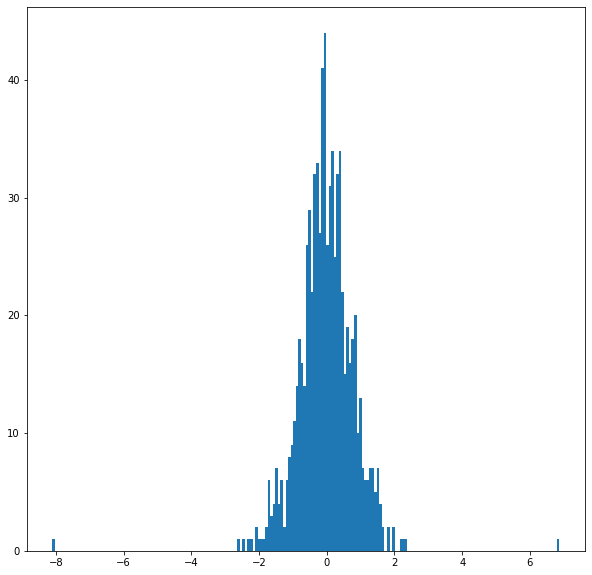

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

In [ ]:
token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 17 x 768


In [ ]:
len(token_vecs_sum)

17

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 замок
2 сто
3 ##ял
4 не
5 ##пр
6 ##ист
7 ##уп
8 ##ныи
9 .
10 замок
11 легко
12 от
13 ##крыл
14 ##ся
15 .
16 [SEP]


In [ ]:
token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
token_vecs.size()

torch.Size([17, 768])

In [ ]:
diff_bank = 1 - cosine(token_vecs_sum[1], token_vecs_sum[10])
diff_bank1 = 1 - cosine(token_vecs[1], token_vecs[10])
# same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)
# print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.92
